In [17]:
import os
from dotenv import load_dotenv

load_dotenv()

AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')
AWS_BUCKET_NAME = os.getenv('AWS_BUCKET_NAME')
AWS_DEFAULT_REGION = os.getenv('AWS_DEFAULT_REGION')

In [2]:
AWS_BUCKET_NAME

'annual-report-rag'

- already created knowledge base
- function to upload a new file
- sync knowledge base
- then call retrive and generate api

In [18]:
import boto3
import time
from PyPDF2 import PdfReader, PdfWriter
import io
from pathlib import Path


In [26]:
knowledge_base_id = "KKMQULBTIX"     # ID of your Knowledge Base
data_source_id    = "QHOXJA8BHP"     # ID of the S3 data source
s3_prefix = "reports/"        # path inside S3

In [20]:
# -------- Clients --------
s3 = boto3.client(
    "s3", 
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_DEFAULT_REGION
    )
bedrock = boto3.client(
    "bedrock-agent",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_DEFAULT_REGION
    )

In [9]:
def chunk_upload(file_path, chunk_size):
    with open(file_path, "rb") as f:
        file_name = Path(file_path).stem
        pdf_reader = PdfReader(f)
        for start in range(0, len(pdf_reader.pages), chunk_size):
            end = min(start + chunk_size, len(pdf_reader.pages))

            writer = PdfWriter()
            for page_num in range(start, end):
                writer.add_page(pdf_reader.pages[page_num])

            buffer = io.BytesIO()
            writer.write(buffer)
            buffer.seek(0)

            object_key = f"{s3_prefix}{file_name}_split_{start+1}_to_{end}.pdf"
            print(f"Uploading: {object_key}")

            s3.upload_fileobj(buffer, AWS_BUCKET_NAME, object_key)



In [10]:
chunk_upload('../data/asian_paints.pdf', chunk_size=50)

Uploading: reports/asian_paints_split_1_to_50.pdf
Uploading: reports/asian_paints_split_51_to_100.pdf
Uploading: reports/asian_paints_split_101_to_150.pdf
Uploading: reports/asian_paints_split_151_to_200.pdf
Uploading: reports/asian_paints_split_201_to_250.pdf
Uploading: reports/asian_paints_split_251_to_283.pdf


In [11]:
print("Starting ingestion job (sync)...")

response = bedrock.start_ingestion_job(
    knowledgeBaseId=knowledge_base_id,
    dataSourceId=data_source_id
)

job_id = response["ingestionJob"]["ingestionJobId"]
print(f"Ingestion job started: {job_id}")

Starting ingestion job (sync)...
Ingestion job started: Y1JVGSILCL


In [12]:
def wait_for_job():
    while True:
        status = bedrock.get_ingestion_job(
            knowledgeBaseId=knowledge_base_id,
            dataSourceId=data_source_id,
            ingestionJobId=job_id
        )["ingestionJob"]["status"]

        print("Job status:", status)

        if status in ["COMPLETE", "FAILED"]:
            return status

        time.sleep(10)

status = wait_for_job()
print("Final ingestion status:", status)

Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_P

In [10]:
bedrock_agent_runtime = boto3.client(
    "bedrock-agent-runtime",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_DEFAULT_REGION
    )

query = "Who were the board of directors?"

response = bedrock_agent_runtime.retrieve(
    knowledgeBaseId=knowledge_base_id,
    retrievalQuery={"text": query},
    retrievalConfiguration={"vectorSearchConfiguration": {"numberOfResults": 3}}
)


In [11]:
len(response['retrievalResults'])

3

In [24]:
response['retrievalResults'][0]['content']

{'type': 'TEXT',
 'text': '<markdown>\n# Notes to the Standalone Financial Statements (Contd.)\n## Note 37: Related Party Transactions\n### Disclosure on Related Party Transactions as required by Ind AS 24 - Related Party Disclosures is given below:\n#### a) Associates:\n1. **PPG Asian Paints Private Limited**\n   - Wholly owned subsidiaries of PPG Asian Paints Private Limited:\n     - a) Revocoat India Private Limited\n     - b) PPG Asian Paints Lanka Private Limited **\n2. **Obgenix Software Private Limited ***\n#### b) Subsidiaries: (where control exists)\n##### Direct Subsidiaries:\n| Name of the Company | Country of Incorporation | % of Holding as at 31.03.2025 | % of Holding as at 31.03.2024 |\n|-|-|-|-|\n| Asian Paints Industrial Coatings Limited | India | 100.00 | 100.00 |\n| Asian Paints International Private Limited (APIPL) | Singapore | 100.00 | 100.00 |\n| Asian Paints (Polymers) Private Limited | India | 100.00 | 100.00 |\n| Asian White Cement Holding Limited ^ | U.A.E | 7

{'content': {'type': 'IMAGE',
  'byteContent': ''},
 'location': {'type': 'S3',
  's3Location': {'uri': 's3://annual-report-rag/reports/asian_paints_split_51_to_100.pdf'}},
 'score': 0.60056365,
 'metadata': {'x-amz-bedrock-kb-source-uri': 's3://annual-report-rag/reports/asian_paints_split_51_to_100.pdf',
  'x-amz-bedrock-kb-document-page-number': 27.0,
  'x-amz-bedrock-kb-description': '## GOVERNANCE\n### BOARD EFFECTIVENESS\nWe believe a diverse and engaged Board is essential to long-term success. Our Board brings together an optimum mix of Executive, Non-Executive, and Independent Directors, with rich diversity in thought, expertise, gender, and experience. This ensures well-rounded deliberation and high-quality decision-making.\nRead more about our Board of Directors on  Pg-  237\n<figure>\nInsights into Board discussions\n| | Strategy | Financial and business performance review | Governance and risk management | Operational and functional | People and organisational |\n| - | - | -
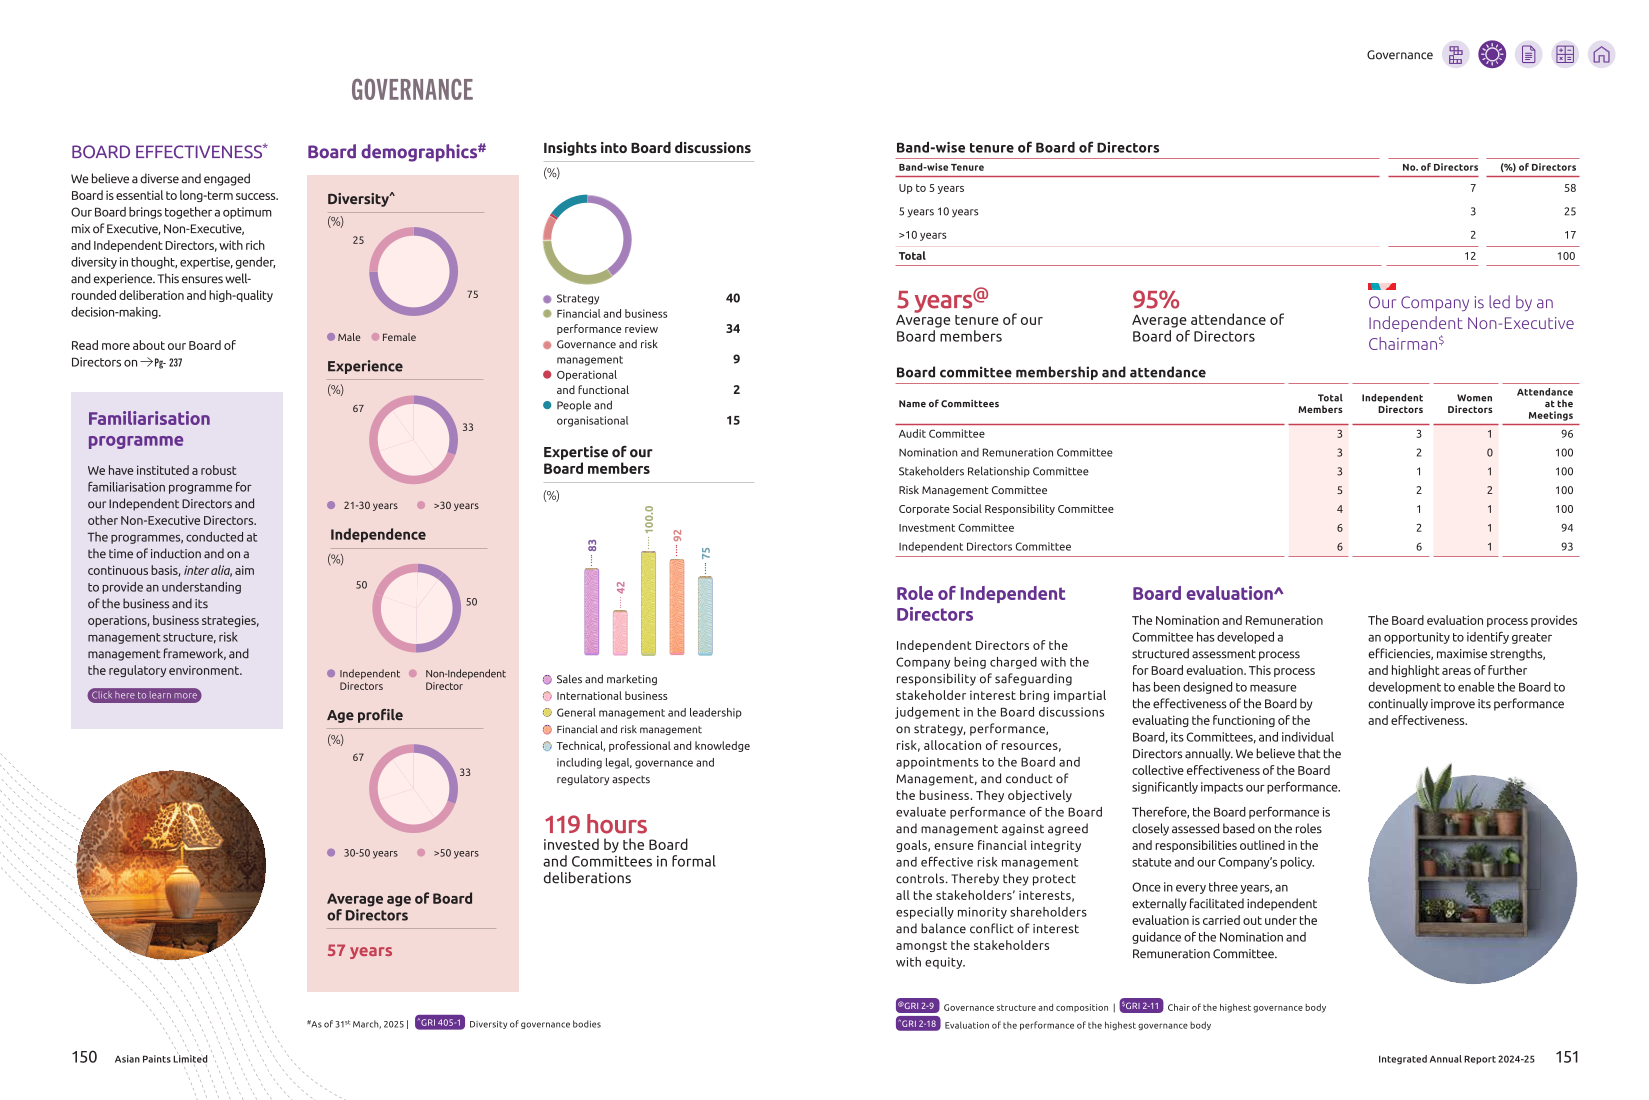

In [18]:
response['retrievalResults'][1]

In [17]:
response['retrievalResults'][1]['metadata']['x-amz-bedrock-kb-description']

'## GOVERNANCE\n### BOARD EFFECTIVENESS\nWe believe a diverse and engaged Board is essential to long-term success. Our Board brings together an optimum mix of Executive, Non-Executive, and Independent Directors, with rich diversity in thought, expertise, gender, and experience. This ensures well-rounded deliberation and high-quality decision-making.\nRead more about our Board of Directors on  Pg-  237\n<figure>\nInsights into Board discussions\n| | Strategy | Financial and business performance review | Governance and risk management | Operational and functional | People and organisational |\n| - | - | - | - | - | - |\n| | 40 | 34 | 9 | 2 | 15 |\n</figure>\n<figure>\nExpertise of our Board members\n| | Sales and marketing | International business | General management and leadership | Financial and risk management | Technical, professional and knowledge including legal, governance and regulatory aspects |\n| - | - | - | - | - | - |\n| | 83 | 42 | 92 | 75 | 100 |\n</figure>\n<figure>\nBoa

In [12]:
def build_context_from_retrievals(retrievals, max_chars=None):
    """
    Build a single context string from retrieval results.
    retrievals: list of dicts [{"text": "...", "source": "s3://.../chunk.pdf"}, ...]
    max_chars: optional max characters to keep (simple guard for context window)
    """
    context = []
    for i, r in enumerate(retrievals, 1):
        if r['content']['type'] == 'IMAGE':
            context.append(r['metadata']['x-amz-bedrock-kb-description'].strip() + "\n\n")
        elif r['content']['type'] == 'TEXT':
            context.append(r['content']['text'].strip() + "\n\n")

    return "\n\n".join(context)

In [13]:
import tiktoken

def count_tokens(text, model="gpt-4"):
    tokenizer = tiktoken.encoding_for_model(model)
    tokens = tokenizer.encode(text)
    return len(tokens)

context = build_context_from_retrievals(response['retrievalResults'])
token_count = count_tokens(context)
print("Tokens in context:", token_count)


Tokens in context: 4258


In [16]:
from groq import Groq

client = Groq(
    api_key=os.environ.get("GROQ_API_KEY")
)

chat_completion = client.chat.completions.create(
    messages=[
        # Set an optional system message. This sets the behavior of the
        # assistant and can be used to provide specific instructions for
        # how it should behave throughout the conversation.
        {
            "role": "system",
            "content": "You are a question answering assistant. Based on the user query and context you have to generate a response."
        },
        # Set a user message for the assistant to respond to.
        {
            "role": "user",
            "content": f'Query: {query}. Context: {context}',
        }
    ],

    # The language model which will generate the completion.
    model="llama-3.3-70b-versatile"
)

# Print the completion returned by the LLM.
print(chat_completion.choices[0].message.content)

The board of directors of Asian Paints Limited consists of the following members:

1. **Amit Syngle** - Managing Director & CEO
2. **R J Jeyamurugan** - CFO & Company Secretary
3. **Deepak Satwalekar** - Chairman (up to 30th September 2023)
4. **R Seshasayee** - Chairman (w.e.f. 1st October 2023)
5. **Amrita Vakil** - Non-Executive Director
6. **Nehal Vakil** - Non-Executive Director
7. **Jigish Choksi** - Non-Executive Director (up to 31st March 2025)
8. **Soumitra Bhattacharya** - Non-Executive Director (w.e.f. 26th October 2023)
9. **Malav Dani** - Non-Executive Director
10. **Milind Sarwate** - Non-Executive Director
11. **Manish Choksi** - Vice Chairman
12. **Ireena Vittal** - Non-Executive Director (w.e.f. 25th July 2023)
13. **Gopichand Katragadda** - Non-Executive Director (w.e.f. 1st April 2024)
14. **Varun Berry** - Non-Executive Director (w.e.f. 23rd October 2024)
15. **Pallavi Shroff** - Non-Executive Director (up to 31st March 2024)
16. **Suresh Narayanan** - Non-Executive

In [ ]:
paginator = s3.get_paginator("list_objects_v2")

In [35]:
for page in paginator.paginate(Bucket=AWS_BUCKET_NAME, Prefix=s3_prefix):
    print(len(page['Contents']))

7


In [36]:
page['Contents']

[{'Key': 'reports/',
  'LastModified': datetime.datetime(2025, 11, 15, 6, 3, 50, tzinfo=tzutc()),
  'ETag': '"d41d8cd98f00b204e9800998ecf8427e"',
  'ChecksumAlgorithm': ['CRC64NVME'],
  'ChecksumType': 'FULL_OBJECT',
  'Size': 0,
  'StorageClass': 'STANDARD'},
 {'Key': 'reports/asian_paints_split_101_to_150.pdf',
  'LastModified': datetime.datetime(2025, 11, 16, 7, 58, 22, tzinfo=tzutc()),
  'ETag': '"c2d7b69626f7e249748fa056fde7d432"',
  'ChecksumAlgorithm': ['CRC32'],
  'ChecksumType': 'FULL_OBJECT',
  'Size': 1423015,
  'StorageClass': 'STANDARD'},
 {'Key': 'reports/asian_paints_split_151_to_200.pdf',
  'LastModified': datetime.datetime(2025, 11, 16, 7, 58, 24, tzinfo=tzutc()),
  'ETag': '"5c9f0fd4e7a64fb9e690c139672240ce"',
  'ChecksumAlgorithm': ['CRC32'],
  'ChecksumType': 'FULL_OBJECT',
  'Size': 1166546,
  'StorageClass': 'STANDARD'},
 {'Key': 'reports/asian_paints_split_1_to_50.pdf',
  'LastModified': datetime.datetime(2025, 11, 16, 7, 58, 5, tzinfo=tzutc()),
  'ETag': '"61da9